Radwatch Efficiency Test Notebook
- using Becquerel fitting

In [1]:
import becquerel as bq
import pandas as pd
from becquerel import Spectrum
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import math as m

In [2]:
spec = Spectrum.from_file('UCB051_Pacific_Cod.Spe') #import spectrum from file
len(spec)

SpeFile: Reading file UCB051_Pacific_Cod.Spe
Line 16451 unknown:  $PRESETS:
Line 16452 unknown:  Live Time
Line 16453 unknown:  80000
Line 16454 unknown:  0


16384

In [3]:
#test spectrum functions
print(spec.start_time)
print(spec.stop_time)
print(spec.realtime)
print(spec.livetime)

2015-02-20 15:17:06
2015-02-21 13:30:42
80016.0
80000.0


8216.0

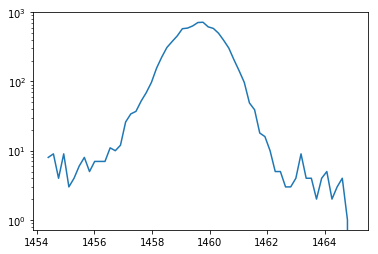

In [42]:
#test plotting
counts = spec.counts_vals
energies = spec.energies_kev
plot_counts = spec.counts_vals[8090+20:8190-20]
plot_energies = spec.energies_kev[8090+20:8190-20]
plt.plot(plot_energies,plot_counts)
plt.yscale('log')
np.argmax(counts)
np.sum(plot_counts)

In [5]:
#input of sources
#energy and activities

#22 sources from Tyler's efficiency csv
#source_energy = np.array([661.657,59.54,238.6,583.2,2614.5,80.8983,276.38,302.85,356.017,383.851,121.7817,244.6975,
#344.2785,411.1163,778.904,867.373,964.079,1085.869,1112.069,1212.948,1299.14,1408.006]);
#22 activity placeholders
#source_activity = np.linspace(1,22,22);

#specific for this spectrum
#https://drive.google.com/drive/u/0/folders/0BwU6Sr8Jh6Sgd2dabnZ6N1ZxMEk
# K-40, Bi-214, Tl-208
# indices 8140, 9835, 14574
source_energy = np.array([1460, 1764, 2614]);
source_activity = np.array([1, 2, 3]);

In [6]:
#convert energies
a = np.transpose(np.vstack((source_energy,source_activity))) #createarray
print(a)

#function to find index of closest energy where a is the desired energy and n is 
def f_near(a,a0):
    idx = np.abs(a - a0).argmin()
    return idx
print(f_near(energies,source_energy[0]))
energies[f_near(energies,source_energy[0])]
energies.argmax()

[[1460    1]
 [1764    2]
 [2614    3]]
8140


16382

Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
erf_amp      1.25e-05        0      inf     None     True     None     None
erf_mu           8140     -inf      inf     None    False gauss_mu     None
erf_sigma          10     -inf      inf     None    False gauss_sigma     None
gauss_amp      0.1086        0      inf     None     True     None     None
gauss_fwhm      23.55     -inf      inf     None    False 2.354820 * gauss_sigma     None
gauss_mu         8140     8040     8240     None     True     None     None
gauss_sigma        10        0      inf     None     True     None     None
line_b       5.625e-05     -inf      inf     None     True     None     None
line_m              0     -inf      inf     None     True     None     None


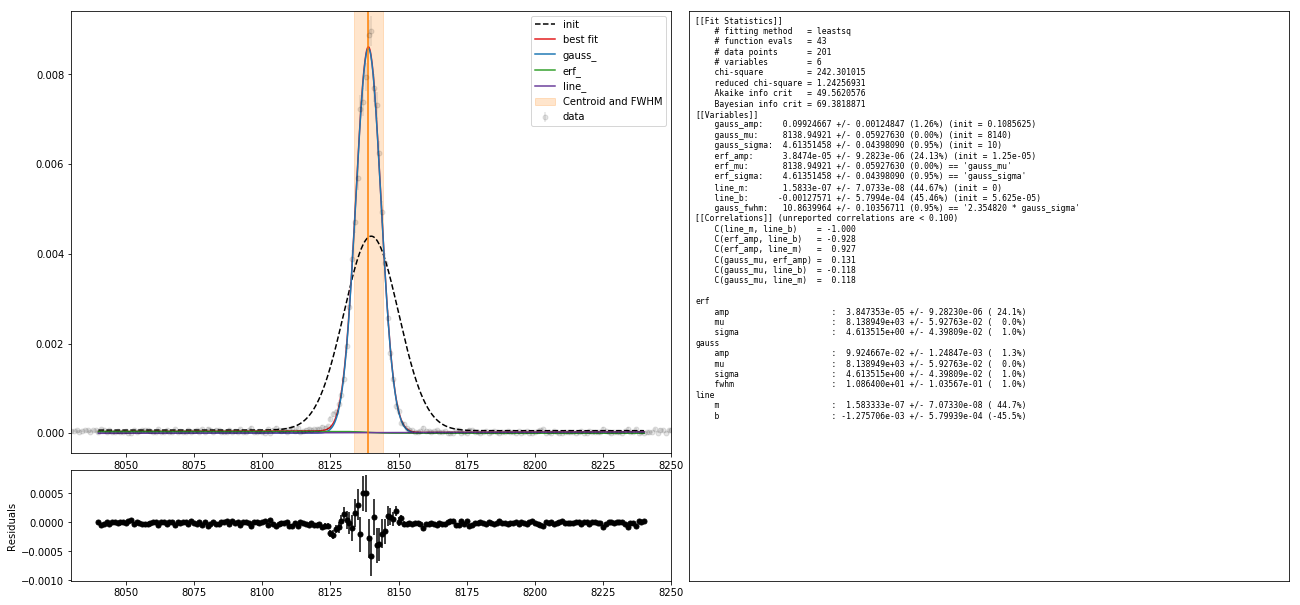

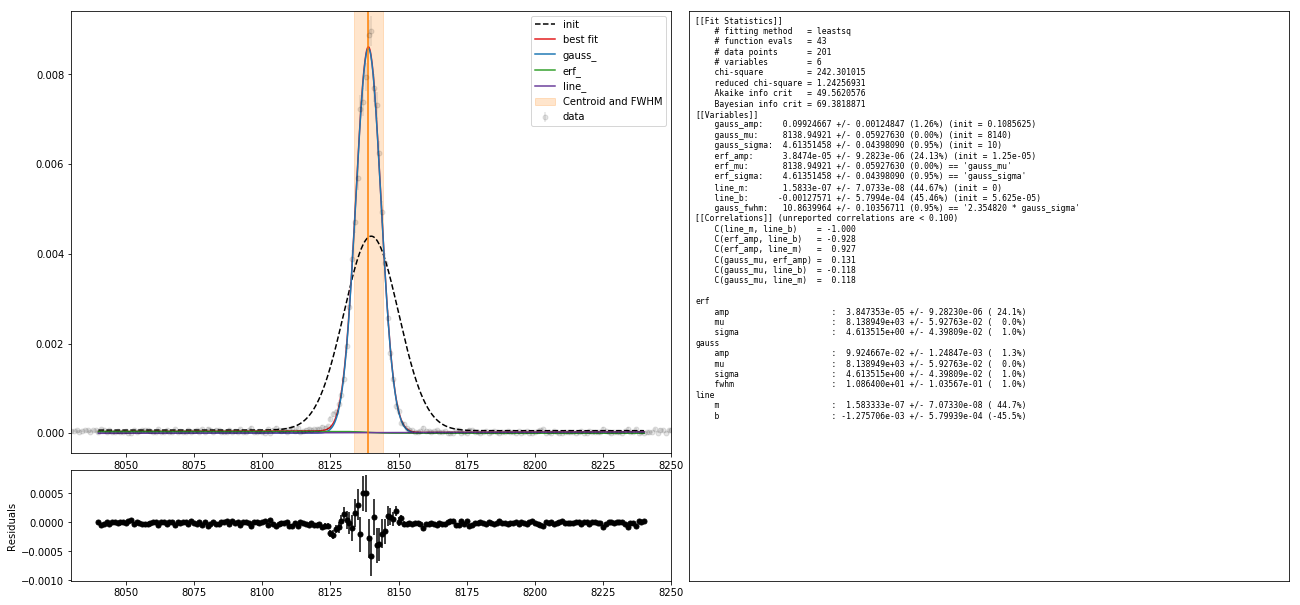

In [7]:
#peak fitting
fit = bq.core.fitting.FitterGaussErfLine(x=spec.channels, y=spec.cps_vals, y_unc=spec.cps_uncs)

idx = f_near(energies,1460)
fit.set_roi(idx-100, idx+100)
fit.fit()
fit.params #type is lmfit.parameter.Parameters
fit.params.pretty_print()
fit.custom_plot()


In [8]:
fit.result.params.pretty_print()

Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
erf_amp      3.847e-05        0      inf 9.282e-06     True     None     None
erf_mu           8139     -inf      inf  0.05928    False gauss_mu     None
erf_sigma       4.614     -inf      inf  0.04398    False gauss_sigma     None
gauss_amp     0.09925        0      inf 0.001248     True     None     None
gauss_fwhm      10.86     -inf      inf   0.1036    False 2.354820 * gauss_sigma     None
gauss_mu         8139     8040     8240  0.05928     True     None     None
gauss_sigma     4.614        0      inf  0.04398     True     None     None
line_b       -0.001276     -inf      inf 0.0005799     True     None     None
line_m       1.583e-07     -inf      inf 7.073e-08     True     None     None


In [9]:
#calculate integral of fitted Gaussian
amp = fit.result.params['gauss_amp'].value
mu = fit.result.params['gauss_mu'].value
sigma =fit.result.params['gauss_sigma'].value
def gaussian(x):
    return (spec.livetime * amp /(m.sqrt(2*m.pi)*sigma)) * m.exp(- ((x-mu)**2) / (2*sigma**2))

integral = integrate.quad(gaussian, 8140-50, 8140+50)

In [10]:
#Now doing it iteratively through all energies
integrals = []

for n in source_energy:
    idx = f_near(energies,n)
    fit.set_roi(idx-100, idx+100)
    fit.fit()
    amp = fit.result.params['gauss_amp'].value
    mu = fit.result.params['gauss_mu'].value
    sigma = fit.result.params['gauss_sigma'].value
    integral = integrate.quad(gaussian, idx-100, idx+100)
    integrals = np.append(integrals,integral[0])
    
print(integrals)

[7939.73387892  174.71181163  448.7497902 ]


9835


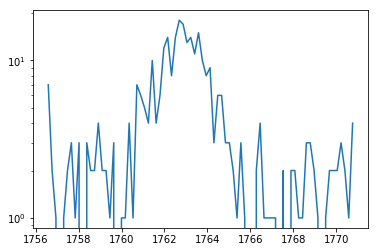

In [11]:
#Testing 1764
idx = f_near(energies,1764)
print(idx)
plot_counts = spec.counts_vals[idx-40:idx+40]
plot_energies = spec.energies_kev[idx-40:idx+40]
plt.plot(plot_energies,plot_counts)
plt.yscale('log')

Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
erf_amp       7.5e-05        0      inf     None     True     None     None
erf_mu           9835     -inf      inf     None    False gauss_mu     None
erf_sigma           4     -inf      inf     None    False gauss_sigma     None
gauss_amp     0.00405        0      inf     None     True     None     None
gauss_fwhm      9.419     -inf      inf     None    False 2.354820 * gauss_sigma     None
gauss_mu         9835     9795     9875     None     True     None     None
gauss_sigma         4        0      inf     None     True     None     None
line_b       5.625e-05     -inf      inf     None     True     None     None
line_m              0     -inf      inf     None     True     None     None
(176.18492892507916, 1.0404142363612534e-07)


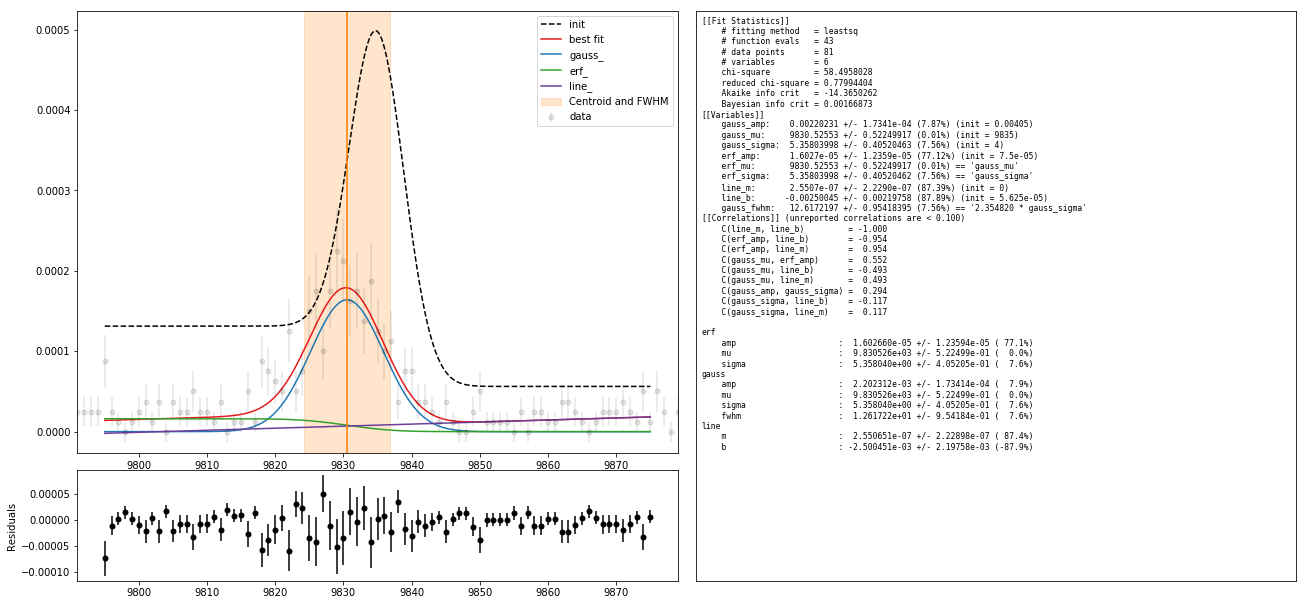

In [12]:
fit.set_roi(idx-40, idx+40)
fit.fit()
fit.params #type is lmfit.parameter.Parameters
fit.params.pretty_print()
fit.custom_plot()
amp = fit.result.params['gauss_amp'].value
mu = fit.result.params['gauss_mu'].value
sigma = fit.result.params['gauss_sigma'].value
integral = integrate.quad(gaussian, idx-100, idx+100)

print(integral)

14574


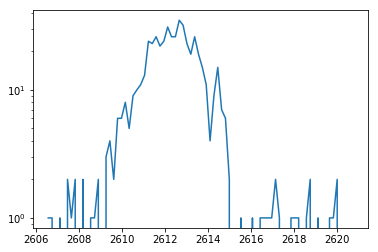

In [13]:
#Testing 2614
idx = f_near(energies,2614)
print(idx)
plot_counts = spec.counts_vals[idx-40:idx+40]
plot_energies = spec.energies_kev[idx-40:idx+40]
plt.plot(plot_energies,plot_counts)
plt.yscale('log')

Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
erf_amp      1.25e-05        0      inf     None     True     None     None
erf_mu       1.457e+04     -inf      inf     None    False gauss_mu     None
erf_sigma           4     -inf      inf     None    False gauss_sigma     None
gauss_amp      0.0067        0      inf     None     True     None     None
gauss_fwhm      9.419     -inf      inf     None    False 2.354820 * gauss_sigma     None
gauss_mu     1.457e+04 1.453e+04 1.461e+04     None     True     None     None
gauss_sigma         4        0      inf     None     True     None     None
line_b       1.25e-05     -inf      inf     None     True     None     None
line_m              0     -inf      inf     None     True     None     None
(448.41048547132414, 7.552419233622723e-09)


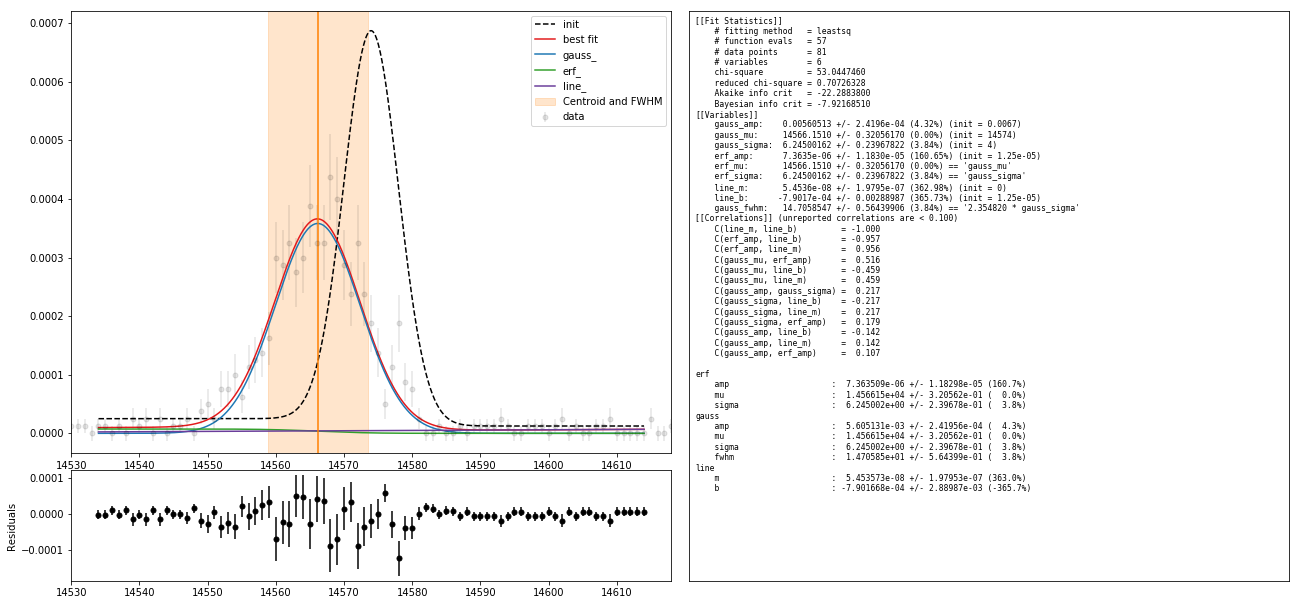

In [14]:
fit.set_roi(idx-40, idx+40)
fit.fit()
fit.params #type is lmfit.parameter.Parameters
fit.params.pretty_print()
fit.custom_plot()
amp = fit.result.params['gauss_amp'].value
mu = fit.result.params['gauss_mu'].value
sigma = fit.result.params['gauss_sigma'].value
integral = integrate.quad(gaussian, idx-100, idx+100)

print(integral)

In [15]:
#pull half lives from becquerel
import becquerel as bq
dir(bq)

['BadInput',
 'EnergyCalError',
 'Isotope',
 'LinearEnergyCal',
 'Spectrum',
 'SpectrumError',
 'UncalibratedError',
 'UncertaintiesError',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'core',
 'fitting',
 'parsers',
 'tools']

In [16]:
dir(bq.tools)

['__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'df_cache',
 'element',
 'fetch_compound_data',
 'fetch_decay_radiation',
 'fetch_element_data',
 'fetch_wallet_card',
 'fetch_xcom_data',
 'isotope',
 'materials',
 'nndc',
 'wallet_cache',
 'xcom']

In [39]:
source_isotopes = np.array(['K-40','Bi-214','Tl-208']);
source_energy = np.array([1460, 1764, 2614]);
source_activity = np.array([1, 2, 3]);

efficiencies = []
for x in range(0,len(source_activity)):
    iso = bq.Isotope(source_isotopes[x])
    efficiency = integrals[x]/source_activity[x]
    efficiencies = np.append(efficiencies,efficiency)


[7939.73387892   87.35590581  149.5832634 ]
